In [1]:
!python --version  # Python 3.10.12
!python -c 'import torch; print(torch.__version__)'  # 2.1.0+cu121
!python -c 'import torchvision; print(torchvision.__version__)'  # 0.16.0+cu121

Python 3.10.12
2.1.0+cu121
0.16.0+cu121


In [2]:
!git clone https://github.com/wakabame/study_pytorch.git
# 処理とは関係ないファイルはすべて削除する
!mv ./study_pytorch ./study_pytorch_
!mv ./study_pytorch_/study_pytorch .
!mv ./study_pytorch_/requirements-colab.txt .
!rm -rf ./study_pytorch_
!pip install -r requirements-colab.txt

Cloning into 'study_pytorch'...
remote: Enumerating objects: 428, done.
remote: Counting objects: 100% (428/428), done.
remote: Compressing objects: 100% (272/272), done.
remote: Total 428 (delta 235), reused 325 (delta 132), pack-reused 0
Receiving objects: 100% (428/428), 3.81 MiB | 21.32 MiB/s, done.
Resolving deltas: 100% (235/235), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.5/162.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.6/153.6 kB 18.1 MB/s eta 0:00:00
     ━

In [4]:
import torchvision
from torchvision import transforms

image_path = "./"
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root=image_path, train=True, transform=transform, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 89114998.17it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 6899173.81it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 29153053.39it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10690532.42it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
import torch
from torch.utils.data import Subset

mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, train=False, transform=transform, download=False)

In [6]:
from torch.utils.data import DataLoader

batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

## Pythorch での CNN の構築
* 2次元の畳み込み層を定義する `nn.Conv2d` クラス
  * 出力チャネルの個数
  * カーネルサイズ
  * オプションパラメータ
    * ストライド、パディングなど
  * NCHW
    * N バッチ内の画像の個数
    * C チャネル
    * H たかさ
    * W 幅
* プーリング層を定義する `nn.MaxPool2d` クラス, `nn.AvgPool2d` クラス
  * ウィンドウのサイズは `kernel_siz`e で決まる（`stride` を使うこともある）
* ドロップアウト（正則化になる）を行う `nn.Dropout` クラス
  * 学習時のみ

In [26]:
import torch.nn as nn

model = nn.Sequential()
model.add_module("conv1", nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module("relu1", nn.ReLU())
model.add_module("pool1", nn.MaxPool2d(kernel_size=2))
model.add_module("conv2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module("relu2", nn.ReLU())
model.add_module("pool2", nn.MaxPool2d(kernel_size=2))

In [27]:
# NCHW形式のテンソルを与えて形状の確認
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [28]:
# 全結合層を作江精
model.add_module("flatten", nn.Flatten())
model(x).shape

torch.Size([4, 3136])

In [29]:
# ドロップアウト層を追加
model.add_module("fc1", nn.Linear(3136, 1024))
model.add_module("relu3", nn.ReLU())
model.add_module("dropout", nn.Dropout(p=0.5))
model.add_module("fc2", nn.Linear(1024, 10))
model.add_module("softmax", nn.Softmax(dim=1))

In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(
            f"Epoch {epoch+1} accurecy: {accuracy_hist_train[epoch]:.4f} "
            f"val_accurecy: {accuracy_hist_valid[epoch]:.4f}"
        )

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [33]:
%%time
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accurecy: 0.9535 val_accurecy: 0.9728
Epoch 2 accurecy: 0.9763 val_accurecy: 0.9783
Epoch 3 accurecy: 0.9818 val_accurecy: 0.9849
Epoch 4 accurecy: 0.9826 val_accurecy: 0.9808
Epoch 5 accurecy: 0.9843 val_accurecy: 0.9834
Epoch 6 accurecy: 0.9860 val_accurecy: 0.9797
Epoch 7 accurecy: 0.9855 val_accurecy: 0.9869
Epoch 8 accurecy: 0.9869 val_accurecy: 0.9852
Epoch 9 accurecy: 0.9873 val_accurecy: 0.9871
Epoch 10 accurecy: 0.9881 val_accurecy: 0.9868
Epoch 11 accurecy: 0.9872 val_accurecy: 0.9873
Epoch 12 accurecy: 0.9880 val_accurecy: 0.9845
Epoch 13 accurecy: 0.9882 val_accurecy: 0.9881
Epoch 14 accurecy: 0.9874 val_accurecy: 0.9850
Epoch 15 accurecy: 0.9870 val_accurecy: 0.9873
Epoch 16 accurecy: 0.9880 val_accurecy: 0.9860
Epoch 17 accurecy: 0.9884 val_accurecy: 0.9861
Epoch 18 accurecy: 0.9871 val_accurecy: 0.9808
Epoch 19 accurecy: 0.9884 val_accurecy: 0.9864
Epoch 20 accurecy: 0.9891 val_accurecy: 0.9815
CPU times: user 1h 9min 56s, sys: 4min 44s, total: 1h 14min 41s
Wall 

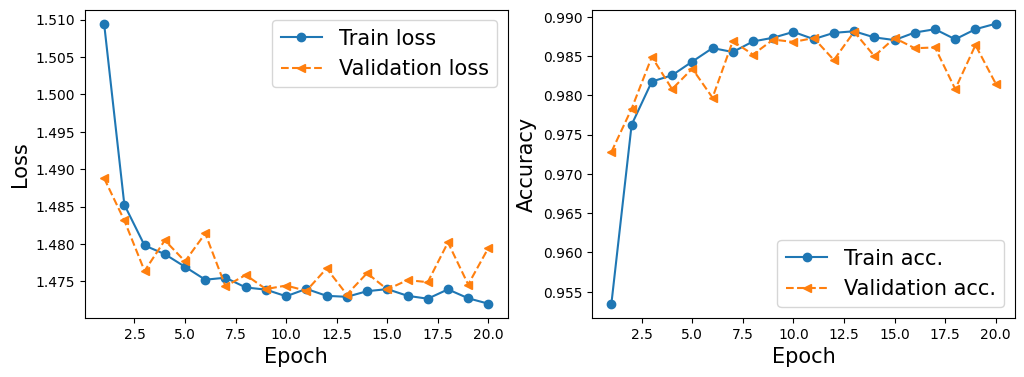

In [34]:
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], "-o", label="Train loss")
ax.plot(x_arr, hist[1], "--<", label="Validation loss")
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Loss", size=15)
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], "-o", label="Train acc.")
ax.plot(x_arr, hist[3], "--<", label="Validation acc.")
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Accuracy", size=15)
ax.legend(fontsize=15)

plt.show()

In [36]:
# テストデータセットでの評価
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.0)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f"Test accurecy: {is_correct.mean():.4f}")

Test accurecy: 0.9842


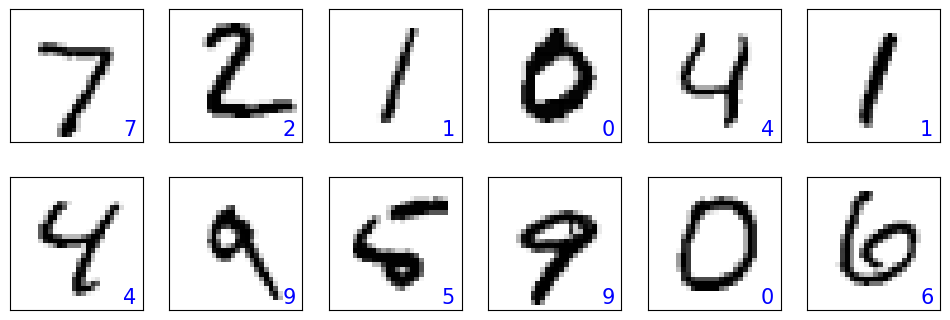

In [39]:
# 入力値と予測したラベルの表示
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap="gray_r")
    ax.text(
        0.9,
        0.1,
        y_pred.item(),
        size=15,
        color="blue",
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
    )

plt.show()